In [30]:
  #!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import struct
import sys

from utility import load_mnist_images, load_mnist_labels, sigmoid, \
init_parameters, create_batch


def extract_target_data(X, Y, target1, target2):
    p1 = (Y == target1)
    p2 = (Y == target2)
    p = p1 | p2
    x_target = X[:,p]
    y_target = Y[p]
    y_target = (y_target == target1)
    y_target = np.expand_dims(y_target, axis=0)
    return x_target, y_target

def compute_cost(X, Y, w, b, lambd, regularized=2):
    m = Y.shape[-1]
    Z = np.dot(w, X) + b
    A = sigmoid(Z)
    cost =  - np.sum(Y * np.log(A) + (1-Y) * np.log(1-A)) / m

    if regularized == 1:
            cost += lambd * np.linalg.norm(w, 1) / m
    elif regularized == 2:
            cost += lambd * np.linalg.norm(w, 2) / m

    return cost


def logistic_propagate(X, Y, w, b, lambd, regularized=2):
    m = Y.shape[-1]
    Z = np.dot(w, X) + b
    A = sigmoid(Z)

    cost = compute_cost(X, Y, w, b, lambd, 2)
    if regularized == 2:
        dw = np.dot((A - Y), X.T) / m + 2 * lambd * w / m
    elif regularized == 1:
        dw = np.dot((A - Y), X.T) / m + 2 * lambd / m
    
    db = np.sum((A - Y), axis=1, keepdims=True) / m
    

    grad = {'dw':dw, 'db':db}

    return grad, cost


def optimize(X, Y, w, b, learning_rate, lambd):
    grad, cost = logistic_propagate(X, Y, w, b, lambd)

    dw = grad['dw']
    db = grad['db']

    w -= learning_rate * dw
    b -= learning_rate * db

    return w, b, cost


class LogisticRegression(object):


    def __init__(self, n_feature, n_epoch, batch_size=32, learning_rate=0.001, lambd=0.01):
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.lambd = lambd
        self.w, self.b = init_parameters(n_feature, 1)
        self.cost = -1.


    def fit(self, X, Y, holdout=0.1, test_X=None, test_Y=None):
        train = {'cost': [], 'accuracy': []}
        val = {'cost': [], 'accuracy':[]}
        test = {'cost':[], 'accuracy':[]}

        m = X.shape[-1]
        permutation = np.random.permutation(m)
        X_shuffle = X[:, permutation]
        Y_shuffle = Y[:, permutation]
        m_holdout = int(m*holdout)


        for i in range(self.n_epoch):
            X_batches, Y_batches, n_batch = create_batch(X[:, m_holdout:], Y[:, m_holdout:], self.batch_size)

            for j in range(n_batch):
                self.w, self.b, self.cost = optimize(X_batches[j], Y_batches[j], self.w, self.b, self.learning_rate, self.lambd)
            valCost = compute_cost(X[:, :m_holdout], Y[:, :m_holdout], self.w, self.b, self.lambd, 2)
            valAcc = self.predict(X[:, :m_holdout], Y[:, :m_holdout])
            
            if i % 20 == 0:
                print('%d epoches cost: %f' % (i, self.cost))

                # Recording data for plotting
                train['cost'].append(self.cost)
                val['cost'].append(valCost)
                train['accuracy'].append(self.predict(X[:, m_holdout:], Y[:, m_holdout:]))
                val['accuracy'].append(valAcc)
                if test_X is not None and test_Y is not None:
                    test['cost'].append(compute_cost(test_X, test_Y, self.w, self.b, self.lambd, 2))
                    test['accuracy'].append(self.predict(test_X, test_Y))



        return train, val, test

    def predict(self, X, Y):
        m = X.shape[-1]

        Z = np.dot(self.w, X) + self.b
        A = sigmoid(Z)

        self.Y_p = (A > 0.5)
        correct = (self.Y_p == Y)
        self.accuracy = np.sum(correct) / m
        return self.accuracy
    
def classify(train_X, test_X, test_labels, c1, c2):
    train_X, train_Y = extract_target_data(train_X, train_labels, c1, c2)
    test_X, test_Y = extract_target_data(test_X, test_labels, c1, c2)

    n_feature = train_X.shape[0]

    sigmoid_2_model = LogisticRegression(n_feature, n_epoch=400)
    train, val, test = sigmoid_2_model.fit(train_X, train_Y, test_X=test_X, test_Y=test_Y)
    sigmoid_2_model.predict(test_X, test_Y)
    print('Softmax Regression on Category %d and %d Accuracy: %f %%' % (c1, c2, sigmoid_2_model.accuracy * 100))

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(211)
    tc_plt, = ax1.plot(train['cost'], label='Training Cost')
    vc_plt, = ax1.plot(val['cost'], label='Validation Cost')
    tec_plt, =  ax1.plot(test['cost'], label='Test Cost')
    ax1.legend(handles=[tc_plt, vc_plt, tec_plt])
    ax2 = fig1.add_subplot(212)
    ta_plt, = ax2.plot(train['accuracy'], label='Training Accuracy')
    va_plt, = ax2.plot(val['accuracy'], label='Validating Accuracy')
    tea_plt, =  ax2.plot(test['accuracy'], label='Test Accuracy')
    ax2.legend(handles=[ta_plt, va_plt, tea_plt], loc=4)
    plt.show()


    fig2 = plt.figure()
    plt.gray()
    ax3 = fig2.add_subplot(111)
    ax3.imshow(sigmoid_2_model.w.reshape(28,28))
    plt.show()




In [15]:
train_images = load_mnist_images('train-images.idx3-ubyte', 20000)
train_labels = load_mnist_labels('train-labels.idx1-ubyte', 20000)
test_images = load_mnist_images('t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('t10k-labels.idx1-ubyte')

test_images = test_images[-2000:]
test_labels = test_labels[-2000:]

'''
# Show A Image
plt.gray()
plt.imshow(train_images[50])
plt.show()
'''

m_train = train_images.shape[0]
m_test = test_images.shape[0]
train_X = train_images.reshape(m_train, -1).T / 255.
test_X = test_images.reshape(m_test, -1).T / 255.
print("Finish loading data")


Finish loading data


0 epoches cost: 0.607292
20 epoches cost: 0.270809
40 epoches cost: 0.124689
60 epoches cost: 0.140249
80 epoches cost: 0.081022
100 epoches cost: 0.231776
120 epoches cost: 0.053590
140 epoches cost: 0.123102
160 epoches cost: 0.182396
180 epoches cost: 0.184661
200 epoches cost: 0.047072
220 epoches cost: 0.050852
240 epoches cost: 0.069046
260 epoches cost: 0.073601
280 epoches cost: 0.045812
300 epoches cost: 0.035358
320 epoches cost: 0.362632
340 epoches cost: 0.094788
360 epoches cost: 0.099658
380 epoches cost: 0.115299
Softmax Regression on Category 2 and 8 Accuracy: 96.623377 %


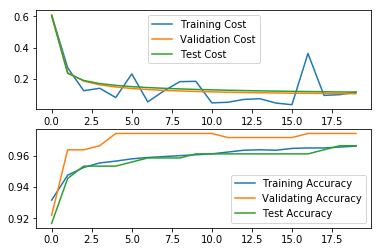

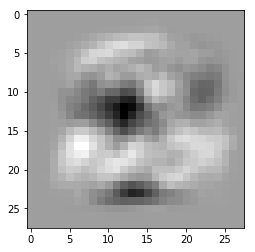

In [16]:
classify(train_X, test_X, test_labels, 2, 8)

0 epoches cost: 0.586793
20 epoches cost: 0.269988
40 epoches cost: 0.127618
60 epoches cost: 0.140625
80 epoches cost: 0.149218
100 epoches cost: 0.336073
120 epoches cost: 0.137757
140 epoches cost: 0.091414
160 epoches cost: 0.075259
180 epoches cost: 0.116198
200 epoches cost: 0.225069
220 epoches cost: 0.192296
240 epoches cost: 0.069242
260 epoches cost: 0.093222
280 epoches cost: 0.186414
300 epoches cost: 0.202263
320 epoches cost: 0.081859
340 epoches cost: 0.128302
360 epoches cost: 0.264638
380 epoches cost: 0.146450
Softmax Regression on Category 2 and 3 Accuracy: 97.777778 %


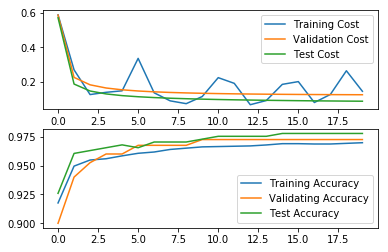

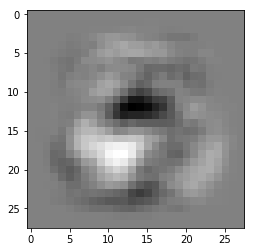

In [17]:
classify(train_X, test_X, test_labels, 2, 3)

In [ ]:
def plot_learning_rate(train_X, test_X, test_labels, c1, c2):
    train_X, train_Y = extract_target_data(train_X, train_labels, c1, c2)
    test_X, test_Y = extract_target_data(test_X, test_labels, c1, c2)

    n_feature = train_X.shape[0]

    sigmoid_2_model = LogisticRegression(n_feature, n_epoch=400)
    acc_l = []
    
    for i in range(-4, 1):
        sigmoid_2_model.learning_rate = 10**(i)
        sigmoid_2_model.w, sigmoid_2_model.b = init_parameters(n_feature, 1)
        train, val, test = sigmoid_2_model.fit(train_X, train_Y, test_X=test_X, test_Y=test_Y)
        sigmoid_2_model.predict(test_X, test_Y)
        acc_l.append(sigmoid_2_model.accuracy)
        print('Softmax Regression on Category %d and %d in learning rate %f Accuracy: %f %%' % (c1, c2, 10**(i), sigmoid_2_model.accuracy * 100))
    print(acc_l)
    plt.plot(range(-4,1), acc_l)
    plt.xlabel('learning rate(log)')
    plt.ylabel('Accuracy(%)')
    plt.show()

In [ ]:
def plot_lambda(train_X, test_X, test_labels, c1, c2):
    train_X, train_Y = extract_target_data(train_X, train_labels, c1, c2)
    test_X, test_Y = extract_target_data(test_X, test_labels, c1, c2)

    n_feature = train_X.shape[0]

    sigmoid_2_model = LogisticRegression(n_feature, n_epoch=400)
    acc_l = []
    
    for i in range(-4, 1):
        sigmoid_2_model.lamda = 10**(i)
        sigmoid_2_model.w, sigmoid_2_model.b = init_parameters(n_feature, 1)
        train, val, test = sigmoid_2_model.fit(train_X, train_Y, test_X=test_X, test_Y=test_Y)
        sigmoid_2_model.predict(test_X, test_Y)
        acc_l.append(sigmoid_2_model.accuracy)
        print('Softmax Regression on Category %d and %d in lamda %f Accuracy: %f %%' % (c1, c2, 10**(i), sigmoid_2_model.accuracy * 100))
    print(acc_l)
    plt.plot(range(-4,1), acc_l)
    plt.xlabel('lambda(log)')
    plt.ylabel('Accuracy(%)')
    plt.show()

0 epoches cost: 0.680578
20 epoches cost: 0.539893
40 epoches cost: 0.378950
60 epoches cost: 0.360114
80 epoches cost: 0.345704
100 epoches cost: 0.203959
120 epoches cost: 0.318694
140 epoches cost: 0.193830
160 epoches cost: 0.156853
180 epoches cost: 0.154891
200 epoches cost: 0.286762
220 epoches cost: 0.248333
240 epoches cost: 0.150657
260 epoches cost: 0.178540
280 epoches cost: 0.190003
300 epoches cost: 0.151577
320 epoches cost: 0.124796
340 epoches cost: 0.094097
360 epoches cost: 0.113364
380 epoches cost: 0.199938
Softmax Regression on Category 2 and 3 in learning rate 0.000100 Accuracy: 96.296296 %
0 epoches cost: 0.581264
20 epoches cost: 0.211419
40 epoches cost: 0.112820
60 epoches cost: 0.117333
80 epoches cost: 0.109373
100 epoches cost: 0.161788
120 epoches cost: 0.061516
140 epoches cost: 0.146436
160 epoches cost: 0.079646
180 epoches cost: 0.062085
200 epoches cost: 0.044053
220 epoches cost: 0.039896
240 epoches cost: 0.263461
260 epoches cost: 0.112152
280 epo

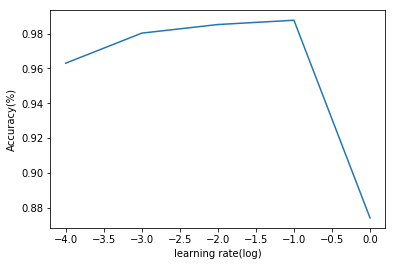

In [50]:
plot_learning_rate(train_X, test_X, test_labels, 2, 3)

0 epoches cost: 0.577976
20 epoches cost: 0.295760
40 epoches cost: 0.215439
60 epoches cost: 0.107065
80 epoches cost: 0.166993
100 epoches cost: 0.129342
120 epoches cost: 0.089294
140 epoches cost: 0.155277
160 epoches cost: 0.188679
180 epoches cost: 0.104296
200 epoches cost: 0.022813
220 epoches cost: 0.055081
240 epoches cost: 0.111171
260 epoches cost: 0.111885
280 epoches cost: 0.041526
300 epoches cost: 0.058084
320 epoches cost: 0.092481
340 epoches cost: 0.063198
360 epoches cost: 0.080819
380 epoches cost: 0.024933
Softmax Regression on Category 2 and 3 in lamda 0.000100 Accuracy: 98.024691 %
0 epoches cost: 0.571625
20 epoches cost: 0.168935
40 epoches cost: 0.121717
60 epoches cost: 0.124581
80 epoches cost: 0.120633
100 epoches cost: 0.030178
120 epoches cost: 0.108028
140 epoches cost: 0.051917
160 epoches cost: 0.175700
180 epoches cost: 0.146990
200 epoches cost: 0.064308
220 epoches cost: 0.118197
240 epoches cost: 0.162591
260 epoches cost: 0.031513
280 epoches cos

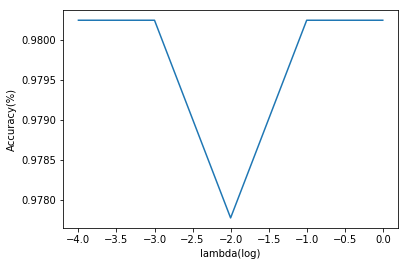

In [49]:
plot_lambda(train_X, test_X, test_labels, 2, 3)